In [21]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model

In [37]:
image_size = 64
latent_size = 128
batch_size = 128
epochs = 25
lr = 0.0002

In [23]:
#building the discriminator

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

In [24]:
building the generator

def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

In [25]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_9 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)      

In [26]:
generator = build_generator()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 4, 4, 512)         1048576   
 Transpose)                                                      
                                                                 
 batch_normalization_12 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 re_lu_4 (ReLU)              (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 256)         2097152   
 Transpose)                                                      
                                                      

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

In [31]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [32]:
data_dir = '/kaggle/input/football-players-and-staff-faces/football'

In [33]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    image_size=(image_size, image_size), 
    batch_size=batch_size, 
    label_mode=None
)
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

Found 8599 files belonging to 1 classes.


In [34]:
#import time
#import os

#os.makedirs('images')

FileExistsError: [Errno 17] File exists: 'images'

In [38]:
#training the model in loop 

for epoch in range(epochs):
    for image_batch in train_dataset:
        train_step(image_batch)

In [39]:
num_samples = 9
sample_noise = tf.random.normal([num_samples, latent_size])
sample_images = generator(sample_noise)
sample_images = 0.5 * sample_images + 0.5  # Denormalize
sample_images = np.clip(sample_images, 0, 1)  # Clip values to [0, 1]

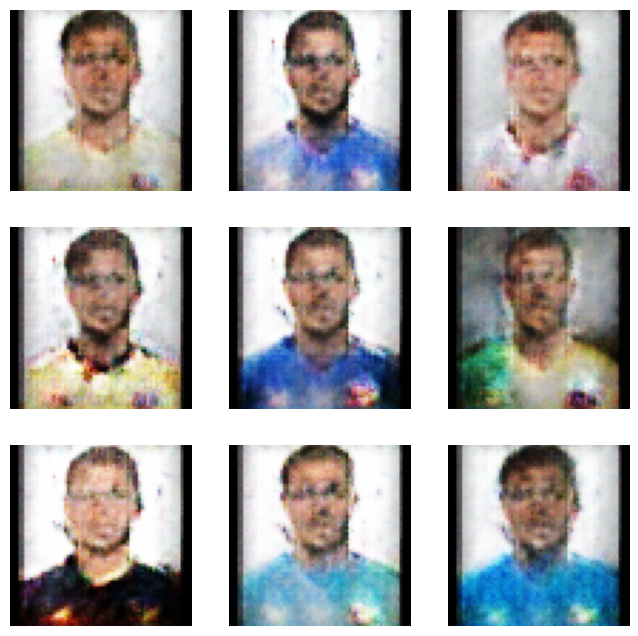

In [40]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_samples):
    axs[i // 3, i % 3].imshow(sample_images[i])
    axs[i // 3, i % 3].axis('off')
plt.show()

In [36]:
#train(train_dataset, epochs)

Time for epoch 1 is 282.01882696151733 sec


NameError: name 'sample_images' is not defined

In [ ]:
#for epoch in range(epochs):
    #for image_batch in train_dataset:
        #train_step(image_batch)

In [ ]:
#num_samples = 9
#sample_noise = tf.random.normal([num_samples, latent_size])
#sample_images = generator(sample_noise)
#sample_images = 0.5 * sample_images + 0.5  # Denormalize
#sample_images = np.clip(sample_images, 0, 1)  # Clip values to [0, 1]

In [ ]:
#fig, axs = plt.subplots(3, 3, figsize=(8, 8))
#for i in range(num_samples):
    #axs[i // 3, i % 3].imshow(sample_images[i])
    #axs[i // 3, i % 3].axis('off')
#plt.show()